# EDA & Preprocessing


In [1]:
#bring in packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", palette="deep")
from datetime import datetime

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex

In [2]:
#bring in data
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

data1 = pd.read_csv('data/LoanStats3a.csv', low_memory=False, skiprows=1, usecols=range(2,145), 
                    parse_dates=date_cols, infer_datetime_format=True)
data2 = pd.read_csv('data/LoanStats3b.csv', low_memory=False, skiprows=1, usecols=range(2,145), 
                    parse_dates=date_cols, infer_datetime_format=True)
data3 = pd.read_csv('data/LoanStats3c.csv', low_memory=False, skiprows=1, usecols=range(2,145),
                    parse_dates=date_cols, infer_datetime_format=True)
data4 = pd.read_csv('data/LoanStats3d.csv', low_memory=False, skiprows=1, usecols=range(2,145),
                    parse_dates=date_cols, infer_datetime_format=True)

In [3]:
data = data1.append(data2)
data = data.append(data3)
data = data.append(data4)

In [4]:
data.shape

(887449, 143)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887449 entries, 0 to 421096
Columns: 143 entries, loan_amnt to settlement_term
dtypes: datetime64[ns](5), float64(106), object(32)
memory usage: 975.0+ MB


In [6]:
#look at categorical variables
#data.describe(include=['O']).T

In [7]:
#look at numerical variables
#data.describe().T

loan_status
Charged Off                                            125309
Current                                                247699
Default                                                   123
Does not meet the credit policy. Status:Charged Off       761
Does not meet the credit policy. Status:Fully Paid       1988
Fully Paid                                             493840
In Grace Period                                          5476
Late (16-30 days)                                        2426
Late (31-120 days)                                       9818
Name: loan_status, dtype: int64


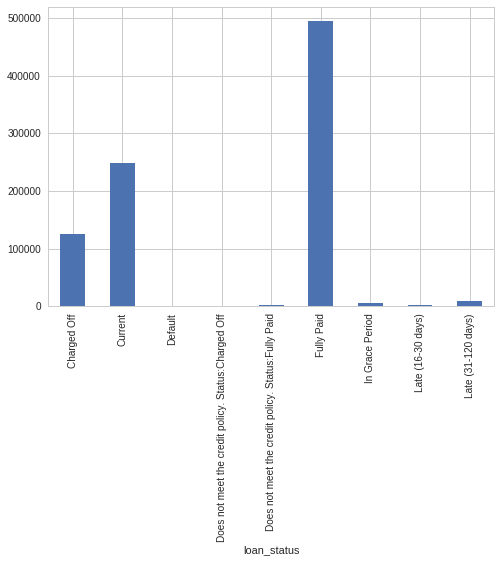

In [8]:
#look at the feature that will be the 'y' - loan status distribution 
loans_by_status = data.groupby('loan_status')
print(loans_by_status['loan_status'].count())
loans_by_status['loan_status'].count().plot(kind='bar')

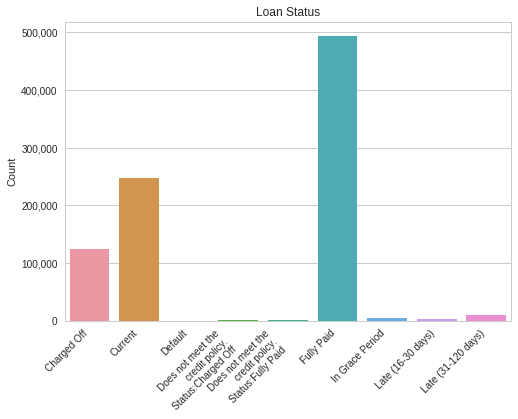

In [9]:
#look at target variable
sns.countplot(data.loan_status, order=['Charged Off', 'Current', 'Default', 'Does not meet the credit policy. Status:Charged Off',
        'Does not meet the credit policy. Status:Fully Paid', 
        'Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'])
plt.xlabel('')
plt.ylabel('Count')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
#ax.set_xticklabels(labels, rotation=45)
plt.title('Loan Status')
from textwrap import wrap
labels=['Charged Off', 'Current', 'Default', 'Does not meet the credit policy. Status:Charged Off',
        'Does not meet the credit policy. Status:Fully Paid', 
        'Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
ax.set_xticklabels(labels, rotation=45, ha = 'right')
plt.tight_layout

plt.savefig('figures/LoanStatus.png', bbox_inches='tight')

In [10]:
#create new column for binary classification on default/no-default loans
data['default'] = None

In [11]:
#combine loan statuses into default (0) and not default (1)
data.loc[(data.loan_status == 'Fully Paid') | 
         (data.loan_status == 'Does not meet the credit policy. Status:Fully Paid'),
         'default'] = 1
data.loc[(data.loan_status == 'Charged Off') | 
         (data.loan_status == 'Does not meet the credit policy. Status:Charged Off') |
         (data.loan_status == 'Default'),
         'default'] = 0

#drop loans that are still active
data_subset = data[~data.default.isnull()]

In [12]:
#encode default column as numeric
data_subset['default'] = pd.to_numeric(data_subset['default'])

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
data_subset.shape

(622021, 144)

In [14]:
data_subset['purpose'].value_counts() 

debt_consolidation    369479
credit_card           136883
home_improvement       36325
other                  31358
major_purchase         12760
small_business          8322
car                     6818
medical                 6227
moving                  4118
vacation                3553
house                   2977
wedding                 2322
renewable_energy         456
educational              423
Name: purpose, dtype: int64

In [15]:
data_subset['loan_purpose'] = None  #create new empty column

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
#combine purpose categories
data_subset.loc[(data_subset.purpose == 'debt_consolidation') |
                   (data_subset.purpose == 'credit_card') |
                   (data_subset.purpose == 'educational'), 
                   'loan_purpose'] = 'debt_payoff'
data_subset.loc[(data_subset.purpose == 'home_improvement') |
                (data_subset.purpose == 'house') | 
                (data_subset.purpose == 'moving') , 'loan_purpose'] = 'house'
data_subset.loc[(data_subset.purpose == 'major_purchase') |
                (data_subset.purpose == 'car'), 'loan_purpose'] = 'large_purchase'
data_subset.loc[(data_subset.purpose == 'medical'), 'loan_purpose'] = 'medical'
data_subset.loc[(data_subset.purpose == 'other') |
                (data_subset.purpose == 'wedding') |
                (data_subset.purpose == 'vacation') |
                (data_subset.purpose == 'renewable_energy'), 'loan_purpose'] = 'other'
data_subset.loc[(data_subset.purpose == 'small_business'), 'loan_purpose'] = 'business'

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
data_subset.emp_length.replace(['n/a'], [np.nan], inplace=True)
data_subset['employ_length'] = None

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
#combine employment categories
data_subset.loc[(data_subset.emp_length == '< 1 year') |
                (data_subset.emp_length == '1 year') | 
                (data_subset.emp_length == '2 years'), 'employ_length'] = '<= 2yr'
data_subset.loc[(data_subset.emp_length == '3 years') |
                (data_subset.emp_length == '4 years') |
                (data_subset.emp_length == '5 years') |
                (data_subset.emp_length == '6 years') |
                (data_subset.emp_length == '7 years'), 'employ_length'] = '3 - 7 yrs'
data_subset.loc[(data_subset.emp_length == '8 years') |
                (data_subset.emp_length == '9 years') |
                (data_subset.emp_length == '10+ years'), 'employ_length'] = '>= 8yrs'

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
#create new column for 'credit_life_mths'  months from first time opened credit to loan issues/fund date
data_subset['credit_life_mths'] = (data_subset.issue_d - data_subset.earliest_cr_line)/ np.timedelta64(1, 'M')

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
data_subset['home_owner'] = None  #create new empty column

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
#combine home ownership categories into 4 groups
data_subset.loc[(data_subset.home_ownership == 'OTHER') |
                   (data_subset.home_ownership == 'NONE') |
                   (data_subset.home_ownership == 'ANY'), 
                   'home_owner'] = 'OTHER'
data_subset.loc[(data_subset.home_ownership == 'RENT'), 'home_owner'] = 'RENT'
data_subset.loc[(data_subset.home_ownership == 'MORTGAGE'), 'home_owner'] = 'MORTGAGE'
data_subset.loc[(data_subset.home_ownership == 'OWN'), 'home_owner'] = 'OWN'

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622021 entries, 0 to 421094
Columns: 148 entries, loan_amnt to home_owner
dtypes: datetime64[ns](5), float64(107), int64(1), object(35)
memory usage: 727.1+ MB


In [23]:
#drop JOINT applications 
data_subset = data_subset.drop(data_subset[data_subset.application_type == 'JOINT'].index)

#remove unnecessary and superfluous features
drop_cols = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
             'open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
             'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 
             'total_cu_tl', 'inq_last_12m', 'emp_title', 'desc', 'url', 'pymnt_plan', 'next_pymnt_d', 
             'title', 'loan_status', 'initial_list_status', 'home_ownership', 'purpose', 
             'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'revol_util',
             'application_type', 'policy_code', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
             'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
             'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'acc_now_delinq',
             'grade', 'sub_grade', 'emp_length', 'open_act_il', 
             'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
             'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
             'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
             'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
             'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
             'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
             'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 
             'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 
             'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type', 'hardship_reason',
             'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 
             'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
             'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 
             'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date',
             'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term'] 

data_subset.drop(drop_cols, axis=1, inplace=True)

In [24]:
#impute the median annual income if null
data_subset['annual_inc'].fillna((data_subset['annual_inc'].median()), inplace=True)

In [25]:
#replace nan's with 0's for certain columns
data_subset['mths_since_last_delinq'] = data_subset['mths_since_last_delinq'].replace(np.nan, 0)
data_subset['mths_since_last_major_derog'] = data_subset['mths_since_last_major_derog'].replace(np.nan, 0)
data_subset['mths_since_last_record'] = data_subset['mths_since_last_record'].replace(np.nan, 0)
data_subset['delinq_2yrs'] = data_subset['delinq_2yrs'].replace(np.nan, 0)
data_subset['collections_12_mths_ex_med'] = data_subset['collections_12_mths_ex_med'].replace(np.nan, 0)

In [26]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622021 entries, 0 to 421094
Data columns (total 36 columns):
loan_amnt                      622021 non-null float64
term                           622021 non-null object
annual_inc                     622021 non-null float64
verification_status            622021 non-null object
issue_d                        622021 non-null datetime64[ns]
zip_code                       622021 non-null object
addr_state                     622021 non-null object
dti                            622019 non-null float64
delinq_2yrs                    622021 non-null float64
earliest_cr_line               621992 non-null datetime64[ns]
inq_last_6mths                 621992 non-null float64
mths_since_last_delinq         622021 non-null float64
mths_since_last_record         622021 non-null float64
open_acc                       621992 non-null float64
pub_rec                        621992 non-null float64
revol_bal                      622021 non-null float64

In [27]:
data_subset = data_subset.dropna()

In [28]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518735 entries, 0 to 421094
Data columns (total 36 columns):
loan_amnt                      518735 non-null float64
term                           518735 non-null object
annual_inc                     518735 non-null float64
verification_status            518735 non-null object
issue_d                        518735 non-null datetime64[ns]
zip_code                       518735 non-null object
addr_state                     518735 non-null object
dti                            518735 non-null float64
delinq_2yrs                    518735 non-null float64
earliest_cr_line               518735 non-null datetime64[ns]
inq_last_6mths                 518735 non-null float64
mths_since_last_delinq         518735 non-null float64
mths_since_last_record         518735 non-null float64
open_acc                       518735 non-null float64
pub_rec                        518735 non-null float64
revol_bal                      518735 non-null float64

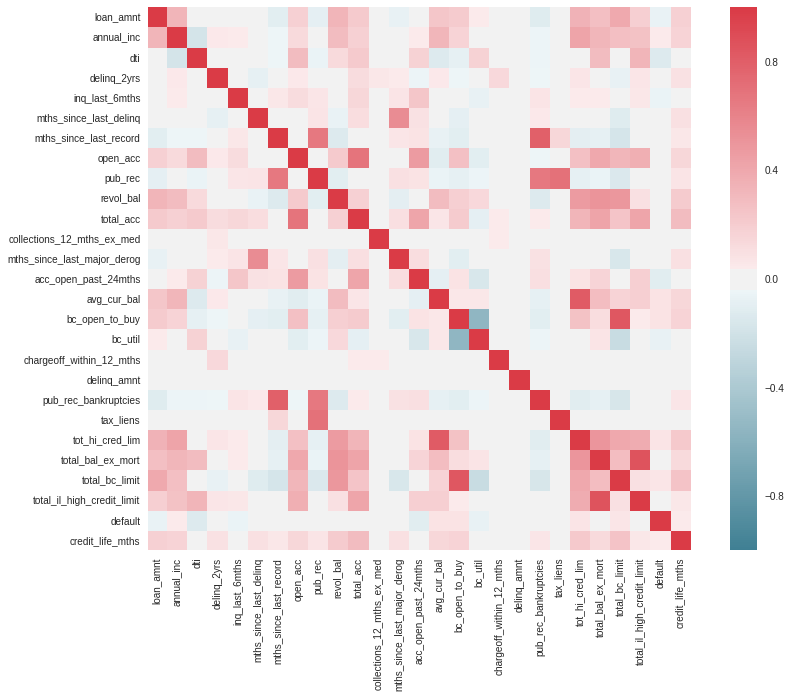

In [29]:
import seaborn as sns

#create dataframe of just numeric fields
cat_feats = ['term', 'employ_length', 'verification_status', 'issue_d', 'loan_purpose', 'zip_code',
             'addr_state', 'earliest_cr_line', 'home_owner']
data_num = data_subset.drop(cat_feats, axis=1)

f, ax = plt.subplots(figsize=(14, 10))
corr = data_num.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.tight_layout

plt.savefig('figures/CorrMap.png', bbox_inches='tight')

In [30]:
corr

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,...,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,credit_life_mths
loan_amnt,1.000000,0.330850,0.024811,-0.004887,-0.014421,-0.032206,-0.108289,0.184494,-0.087741,0.329773,...,0.001451,-0.000959,-0.120955,0.001856,0.344778,0.280124,0.390950,0.191228,-0.065144,0.183404
annual_inc,0.330850,1.000000,-0.187386,0.048092,0.044332,0.013814,-0.042551,0.127332,-0.009675,0.289287,...,0.014707,0.005648,-0.051528,0.037111,0.426230,0.321418,0.278395,0.260682,0.046337,0.166185
dti,0.024811,-0.187386,1.000000,-0.014282,-0.000119,-0.020141,-0.046611,0.291378,-0.057151,0.128375,...,-0.010452,-0.004859,-0.048962,-0.028714,0.000241,0.294323,0.029758,0.333693,-0.128405,0.024949
delinq_2yrs,-0.004887,0.048092,-0.014282,1.000000,0.029028,-0.078325,-0.033478,0.048697,-0.013890,-0.033735,...,0.137632,0.028297,-0.039115,0.012223,0.064882,0.030372,-0.072623,0.063682,-0.018156,0.093681
inq_last_6mths,-0.014421,0.044332,-0.000119,0.029028,1.000000,0.035193,0.055899,0.122513,0.063075,-0.014112,...,0.011772,0.002854,0.077129,0.010133,0.039706,0.042927,-0.014449,0.055795,-0.056810,0.005333
mths_since_last_delinq,-0.032206,0.013814,-0.020141,-0.078325,0.035193,1.000000,0.035311,0.016394,0.071350,-0.068424,...,-0.010400,-0.010472,0.048309,0.029168,-0.012038,-0.006565,-0.123271,0.027553,-0.005873,0.094534
mths_since_last_record,-0.108289,-0.042551,-0.046611,-0.033478,0.055899,0.035311,1.000000,-0.031333,0.663325,-0.126603,...,-0.010715,0.001140,0.792385,0.146662,-0.097549,-0.079849,-0.172821,-0.029842,-0.017349,0.060035
open_acc,0.184494,0.127332,0.291378,0.048697,0.122513,0.016394,-0.031333,1.000000,-0.030726,0.211820,...,0.004809,0.001811,-0.040123,-0.005387,0.271721,0.399376,0.323961,0.363910,-0.038769,0.144235
pub_rec,-0.087741,-0.009675,-0.057151,-0.013890,0.063075,0.071350,0.663325,-0.030726,1.000000,-0.106115,...,-0.004741,0.001286,0.658445,0.697204,-0.079129,-0.061351,-0.142459,-0.017572,-0.018155,0.074963
revol_bal,0.329773,0.289287,0.128375,-0.033735,-0.014112,-0.068424,-0.126603,0.211820,-0.106115,1.000000,...,-0.011848,-0.001664,-0.131966,-0.014640,0.470037,0.514935,0.499093,0.101334,0.016199,0.210848


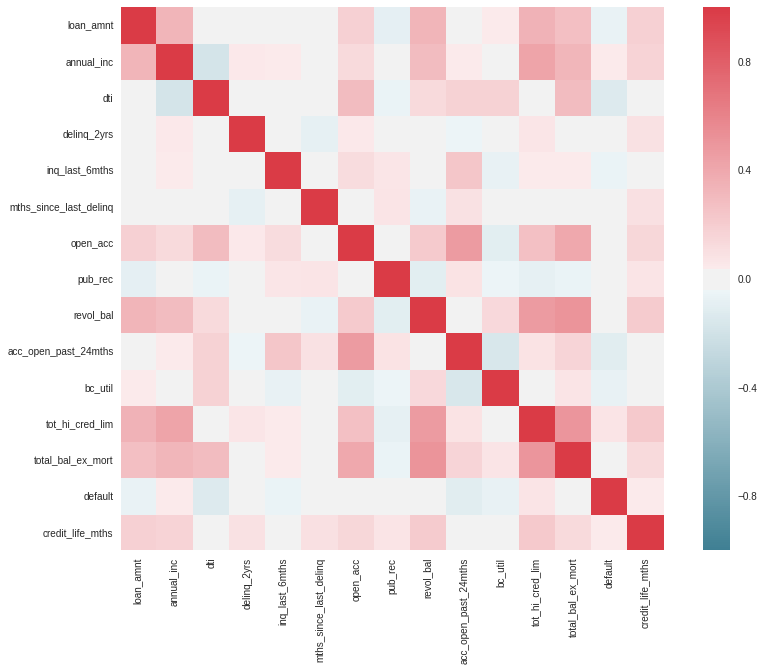

In [31]:
collinear_vars = ['mths_since_last_record', 'mths_since_last_major_derog', 'total_acc', 'total_il_high_credit_limit',
                  'total_bc_limit', 'pub_rec_bankruptcies', 'tax_liens', 'avg_cur_bal',
                  'bc_open_to_buy', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'delinq_amnt']
data_subset = data_subset.drop(collinear_vars, axis=1)

#recreate dataframe of just numeric fields
cat_feats = ['term', 'employ_length', 'verification_status', 'issue_d', 'loan_purpose', 'zip_code',
             'addr_state', 'earliest_cr_line', 'home_owner']
data_num = data_subset.drop(cat_feats, axis=1)

f, ax = plt.subplots(figsize=(14, 10))
corr = data_num.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [32]:
#create pairplot of numeric variables
#sns.set(style='whitegrid', context='notebook')

#sns.pairplot(data_num, hue = 'default', size = 2)
#plt.legend()
#plt.tight_layout()
#plt.show()

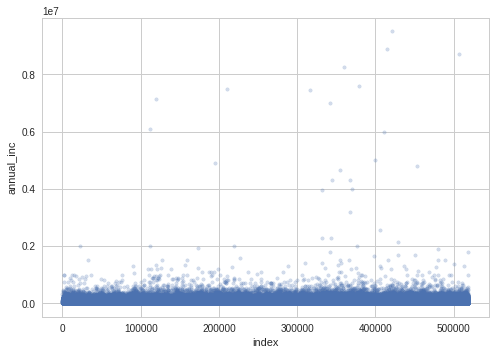

In [33]:
#look at annual income 
plt.scatter(x=range(data_subset['annual_inc'].shape[0]), y=data_subset.annual_inc, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('annual_inc')
ax = plt.gca()

In [34]:
#appears to be some outliers in annual income
np.percentile(data_subset.annual_inc, [50, 75, 85, 90, 95, 97, 98, 99, 100])

array([   65000.,    90000.,   110000.,   125000.,   150000.,   180000.,
         200000.,   250000.,  9500000.])

In [35]:
ann_inc_outliers = np.percentile(data_subset.annual_inc, 99)

#removing annual income greater than 99th percentile 
data_subset_clean = data_subset[(data_subset['annual_inc'] <= ann_inc_outliers)]

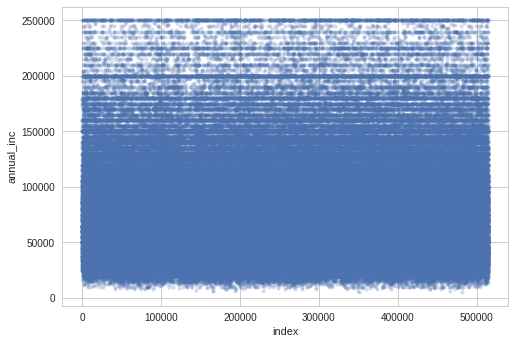

In [36]:
plt.scatter(x=range(data_subset_clean['annual_inc'].shape[0]), y=data_subset_clean.annual_inc, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('annual_inc')
ax = plt.gca()
#looks much better

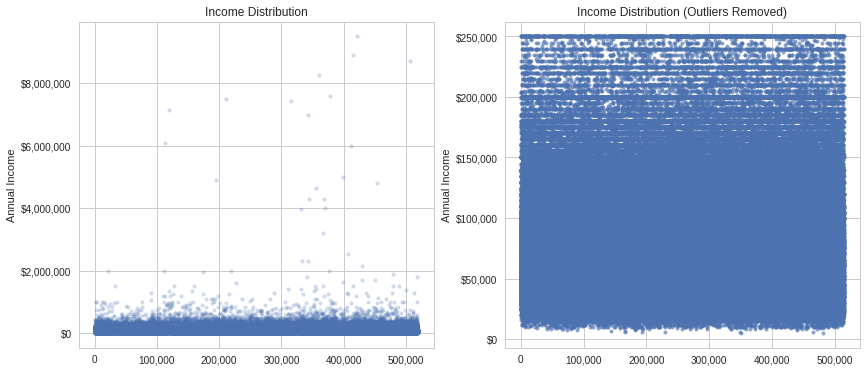

In [37]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(x=range(data_subset['annual_inc'].shape[0]), y=data_subset.annual_inc, marker='.', alpha=0.25)
plt.xlabel('')
plt.ylabel('Annual Income')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Income Distribution')

plt.subplot(1,2,2)
plt.scatter(x=range(data_subset_clean.shape[0]), y=data_subset_clean.annual_inc, marker='.', alpha=0.65)
#plt.xlabel('')
plt.ylabel('Annual Income')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Income Distribution (Outliers Removed)')
plt.tight_layout

plt.savefig('figures/IncPlot.png', bbox_inches='tight')

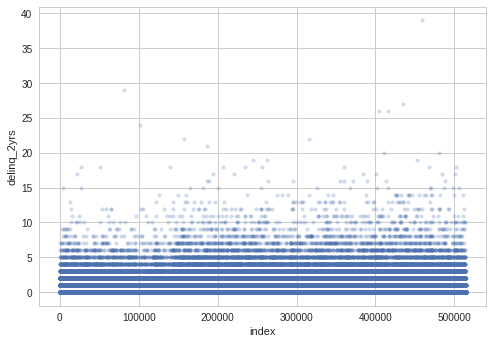

In [38]:
plt.scatter(x=range(data_subset_clean['delinq_2yrs'].shape[0]), y=data_subset_clean.delinq_2yrs, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('delinq_2yrs')
ax = plt.gca()

In [39]:
np.percentile(data_subset_clean.delinq_2yrs, [50, 75, 85, 90, 95, 97, 98, 99, 100])

array([  0.,   0.,   1.,   1.,   2.,   2.,   3.,   4.,  39.])

In [40]:
data_subset.delinq_2yrs.describe()

count    518735.000000
mean          0.315253
std           0.863451
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: delinq_2yrs, dtype: float64

In [41]:
#keep delinq_2yrs data that are within +3 to -3 standard deviations 
data_subset_clean = data_subset_clean[np.abs(data_subset_clean.delinq_2yrs - data_subset_clean.delinq_2yrs.mean()) 
                          <= (3*data_subset_clean.delinq_2yrs.std())]

In [42]:
data_subset_clean.delinq_2yrs.describe()

count    500756.000000
mean          0.209959
std           0.493541
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: delinq_2yrs, dtype: float64

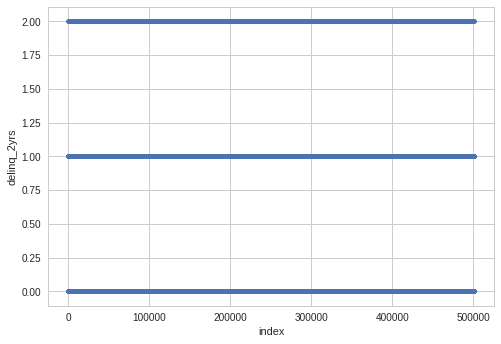

In [43]:
plt.scatter(x=range(data_subset_clean['delinq_2yrs'].shape[0]), y=data_subset_clean.delinq_2yrs, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('delinq_2yrs')
ax = plt.gca()

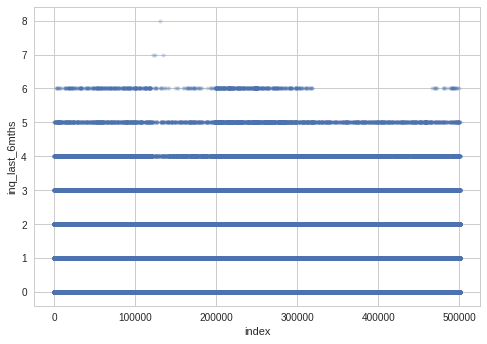

In [44]:
plt.scatter(x=range(data_subset_clean['inq_last_6mths'].shape[0]), y=data_subset_clean.inq_last_6mths, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('inq_last_6mths')
ax = plt.gca()

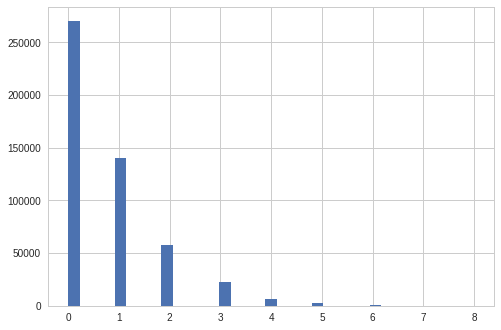

In [45]:
data_subset_clean.inq_last_6mths.hist(bins=35)

In [46]:
np.percentile(data_subset_clean.inq_last_6mths, [75, 85, 90, 95, 96, 97, 98, 99, 100])

array([ 1.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  8.])

In [47]:
data_subset_clean.inq_last_6mths.describe()

count    500756.000000
mean          0.734374
std           1.001601
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           8.000000
Name: inq_last_6mths, dtype: float64

In [48]:
#keep inq_last_6mths data that are within +3 to -3 standard deviations 
data_subset_clean = data_subset_clean[np.abs(data_subset_clean.inq_last_6mths - data_subset_clean.inq_last_6mths.mean()) 
                          <= (3*data_subset_clean.inq_last_6mths.std())]

In [49]:
data_subset_clean.inq_last_6mths.describe()

count    490758.000000
mean          0.660034
std           0.859686
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: inq_last_6mths, dtype: float64

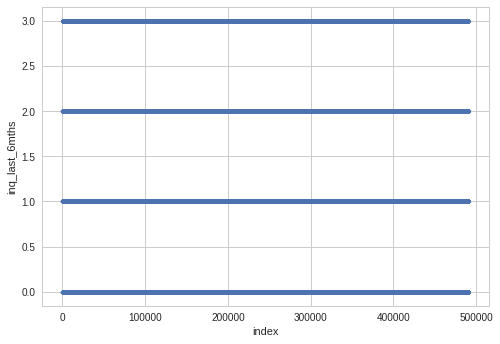

In [50]:
plt.scatter(x=range(data_subset_clean['inq_last_6mths'].shape[0]), y=data_subset_clean.inq_last_6mths, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('inq_last_6mths')
ax = plt.gca()

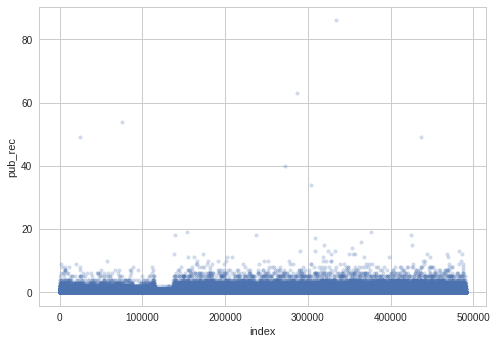

In [51]:
plt.scatter(x=range(data_subset_clean['pub_rec'].shape[0]), y=data_subset_clean.pub_rec, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('pub_rec')
ax = plt.gca()

In [52]:
np.percentile(data_subset_clean.pub_rec, [75, 85, 90, 95, 96, 97, 98, 99, 100])

array([  0.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,  86.])

In [53]:
data_subset_clean.pub_rec.describe()

count    490758.000000
mean          0.197276
std           0.580669
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [54]:
#keep pub_rec data that are within +3 to -3 standard deviations 
data_subset_clean = data_subset_clean[(np.abs(data_subset_clean.pub_rec - data_subset_clean.pub_rec.mean())) 
                          <= (3*data_subset_clean.pub_rec.std())]

In [55]:
data_subset_clean.pub_rec.describe()

count    479019.000000
mean          0.137805
std           0.344695
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: pub_rec, dtype: float64

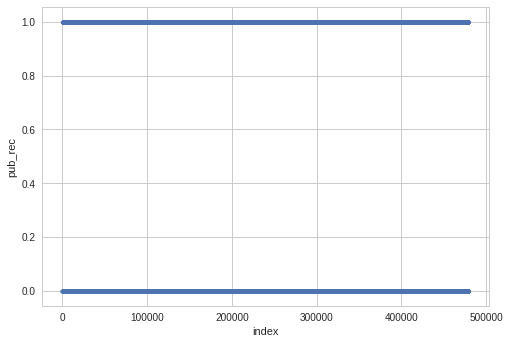

In [56]:
plt.scatter(x=range(data_subset_clean['pub_rec'].shape[0]), y=data_subset_clean.pub_rec, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('pub_rec')
ax = plt.gca()

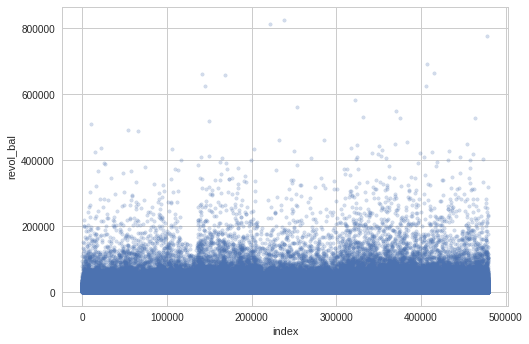

In [57]:
plt.scatter(x=range(data_subset_clean['revol_bal'].shape[0]), y=data_subset_clean.revol_bal, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('revol_bal')
ax = plt.gca()

In [58]:
np.percentile(data_subset_clean.revol_bal, [75, 85, 90, 95, 96, 97, 98, 99, 100])

array([  20503.  ,   27150.  ,   32425.  ,   41714.1 ,   45111.  ,
         49602.46,   59020.64,   82065.96,  824328.  ])

In [59]:
data_subset_clean.revol_bal.describe()

count    479019.000000
mean      16377.317242
std       18510.600031
min           0.000000
25%        6629.000000
50%       11914.000000
75%       20503.000000
max      824328.000000
Name: revol_bal, dtype: float64

In [60]:
#keep revol_bal data that are within +3 to -3 standard deviations 
data_subset_clean = data_subset_clean[np.abs(data_subset_clean.revol_bal - data_subset_clean.revol_bal.mean()) 
                          <= (3*data_subset_clean.revol_bal.std())]

In [61]:
data_subset_clean.revol_bal.describe()

count    472752.000000
mean      14956.878727
std       11674.327075
min           0.000000
25%        6568.000000
50%       11753.000000
75%       20029.250000
max       71907.000000
Name: revol_bal, dtype: float64

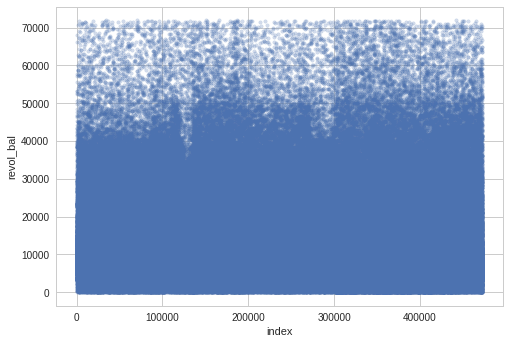

In [62]:
plt.scatter(x=range(data_subset_clean['revol_bal'].shape[0]), y=data_subset_clean.revol_bal, marker='.', alpha=0.25)
plt.xlabel('index')
plt.ylabel('revol_bal')
ax = plt.gca()

In [63]:
data_subset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472752 entries, 0 to 421094
Data columns (total 24 columns):
loan_amnt                 472752 non-null float64
term                      472752 non-null object
annual_inc                472752 non-null float64
verification_status       472752 non-null object
issue_d                   472752 non-null datetime64[ns]
zip_code                  472752 non-null object
addr_state                472752 non-null object
dti                       472752 non-null float64
delinq_2yrs               472752 non-null float64
earliest_cr_line          472752 non-null datetime64[ns]
inq_last_6mths            472752 non-null float64
mths_since_last_delinq    472752 non-null float64
open_acc                  472752 non-null float64
pub_rec                   472752 non-null float64
revol_bal                 472752 non-null float64
acc_open_past_24mths      472752 non-null float64
bc_util                   472752 non-null float64
tot_hi_cred_lim           472

In [64]:
data_subset_clean.head()

,loan_amnt,term,annual_inc,verification_status,issue_d,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,...,revol_bal,acc_open_past_24mths,bc_util,tot_hi_cred_lim,total_bal_ex_mort,default,loan_purpose,employ_length,credit_life_mths,home_owner
0,27050.0,36 months,55000.0,Verified,2013-12-01,481xx,MI,22.87,0.0,1986-10-01,...,36638.0,3.0,53.9,138554.0,70186.0,1,debt_payoff,>= 8yrs,326.019015,OWN
1,12000.0,36 months,60000.0,Not Verified,2013-12-01,281xx,NC,4.62,0.0,2009-12-01,...,7137.0,8.0,15.9,29700.0,7137.0,1,debt_payoff,3 - 7 yrs,48.000986,RENT
2,4800.0,36 months,39600.0,Source Verified,2013-12-01,782xx,TX,2.49,0.0,1995-08-01,...,4136.0,0.0,16.1,25700.0,4136.0,1,house,<= 2yr,220.029159,MORTGAGE
3,12000.0,36 months,130000.0,Source Verified,2013-12-01,809xx,CO,13.03,0.0,1997-11-01,...,10805.0,4.0,93.0,365874.0,44327.0,1,debt_payoff,>= 8yrs,192.989589,MORTGAGE
4,7550.0,36 months,28000.0,Not Verified,2013-12-01,951xx,CA,8.40,0.0,2010-10-01,...,5759.0,1.0,96.0,8000.0,5759.0,1,debt_payoff,3 - 7 yrs,38.013101,RENT


In [65]:
#create data table that shows total defaults by state
data_state = data_subset[['addr_state', 'default']].reset_index(drop=True)
default_total = data_state.groupby('addr_state').sum().reset_index(drop=False)
total_loans = data_state.groupby('addr_state').count().reset_index(drop=False)
state_data = pd.merge(left=default_total, right=total_loans, left_on='addr_state', right_on='addr_state')
cols = ['state', 'total_defaults', 'total_loans']
state_data.columns = cols
state_data['default_rate'] = (state_data['total_defaults'] / state_data['total_loans']) * 100
state_data.head()

,state,total_defaults,total_loans,default_rate
0,AK,1110,1385,80.144404
1,AL,4838,6414,75.428750
2,AR,2851,3752,75.986141
3,AZ,9798,12245,80.016333
4,CA,63966,79297,80.666356


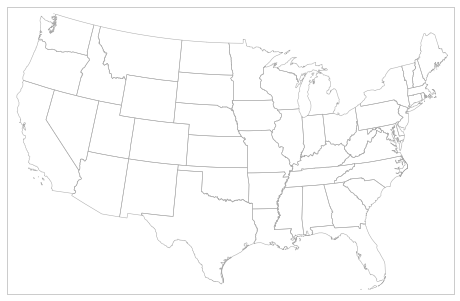

In [66]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('/home/nick/MapData/cb_2016_us_state_5m',
                           name = 'states', drawbounds=True, color = 'darkgray')

#import math   
#import numbers
#patches = []
#population  = []
#for info, shape in zip(m.state_info, m.state):
#    patches.append(Polygon(np.array(shape), True))
#    if( isinstance(info['ST'], numbers.Number)  ):
#        try:
#            z = math.log10(info['POP_EST']+1.0)
#        except:
#            z = 0
#        #end try
#    else:
#        z = 0.0
#    #end if
#    population.append(z)

#print(m.states_info[0].keys())

r = zip(m.states_info, m.states)
print(r)
#m

In [67]:
import folium
import os
import json

state_geo = os.path.join('/home/nick/MapData/', 'us-states.json')

#m = folium.Map(location=[48, -102], zoom_start=4)

#m.choropleth(
    #geo_data=state_geo,
#    name='choropleth',
#    data=data_state,
#    columns=['addr_state', 'default'],
#    key_on='feature.id',
#    fill_color='YlGn',
#    fill_opacity=0.7,
#    line_opacity=0.2,
#    legend_name='Default Rate (%)'
#)


#folium.LayerControl().add_to(m)
threshold_scale = range(0, 100, 10)
m

#Let Folium determine the scale
m = folium.Map(location=[48, -102], zoom_start=4)
m.geo_json(geo_path=state_geo,
           data=state_data,
           #threshold_scale = [0,10,20,30,40,50,60,70,80,90,100],
           columns=['state', 'default_rate'],
           key_on='feature.id',
           fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
           legend_name='Default Rate (%)')
#folium.LayerControl().add_to(m)
m

/home/nick/anaconda3/lib/python3.6/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
/home/nick/anaconda3/lib/python3.6/site-packages/folium/folium.py:506: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
  return self.choropleth(*args, **kwargs)


In [68]:
data_subset_clean.to_csv('data/df_class.csv')